In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
#import torchvision.transforms as transforms


In [2]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [29]:
batch_size = 5

images = np.load('padded_gray_chair_imgs.npy')
images[:] *= 1/images[:].max()#(images[:] - np.mean(images[:])) / np.std(images[:])
voxels = np.load('chair_voxels.npy')
print(images[1:1316].shape)
print(images[1316:1416].shape)
train_images = images[1:1316]
val_images = images[1316:1416]
train_voxels = voxels[1:1316]
val_voxels = voxels[1316:1416]

(1315, 128, 128)
(100, 128, 128)


Displaying the object


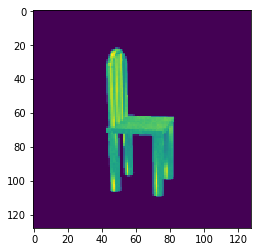

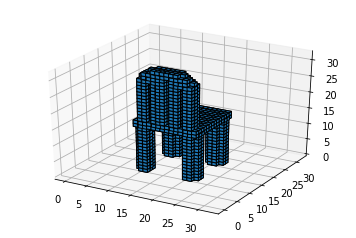

In [30]:
display_id = 56

train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id])
display3DObject(train_voxels[display_id])

In [ ]:
display3DObject(voxels[877])

In [42]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [43]:
vae = VAE().cuda()

In [44]:
lr_vae = 0.001
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
vae_solver = optim.Adam(vae.parameters(), lr=lr_vae) #, betas = adam_beta_vae)

In [45]:
#Training the system
num_epochs = 500
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss()
for epoch in range(num_epochs):
    vae_losses = []
    klds = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float().unsqueeze(1)
        generated_object, mu, sigma = vae(var_2D_data)
        generated_object= generated_object.squeeze()
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD_element = mu.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        loss_ = loss(generated_object, var_3D_data) + KLD
        vae.zero_grad()
        loss_.backward()
        vae_solver.step()
        vae_losses.append(loss_)
        klds.append(KLD)
    val_3D_data = Variable(val_voxels).cuda().float()
    val_2D_data = Variable(val_images).cuda().float().unsqueeze(1)
    generated_object_val, mu, sigma = vae(val_2D_data)
    generated_object_val = torch.round(generated_object_val.squeeze())
    accuracy = np.mean((generated_object_val  == val_3D_data).squeeze().data.cpu().numpy())
    vae_losses_mean = np.mean(np.concatenate(vae_losses))
    kld_mean =  np.mean(np.concatenate(klds)).data.cpu().numpy()[0]
    print("Epoch: ", epoch, '\n', "VAE loss: ", vae_losses_mean.data.cpu().numpy()[0])
    print("Accuracy", accuracy, "KLD loss: ", kld_mean)

Epoch:  0 
 VAE loss:  0.19486447
Accuracy 0.9274981689453125 KLD loss:  2334.4426
Epoch:  1 
 VAE loss:  0.14681023
Accuracy 0.9274981689453125 KLD loss:  5344.457
Epoch:  2 
 VAE loss:  0.13906118
Accuracy 0.9274981689453125 KLD loss:  6067.9834
Epoch:  3 
 VAE loss:  0.13080889
Accuracy 0.9274981689453125 KLD loss:  6539.855
Epoch:  4 
 VAE loss:  0.12674132
Accuracy 0.92749755859375 KLD loss:  7270.3154
Epoch:  5 
 VAE loss:  0.1227854
Accuracy 0.9278717041015625 KLD loss:  7512.1084
Epoch:  6 
 VAE loss:  0.121324204
Accuracy 0.938385009765625 KLD loss:  8466.806
Epoch:  7 
 VAE loss:  0.119887576
Accuracy 0.938045654296875 KLD loss:  8730.351
Epoch:  8 
 VAE loss:  0.117071345
Accuracy 0.939290771484375 KLD loss:  9268.724
Epoch:  9 
 VAE loss:  0.114905916
Accuracy 0.9439950561523438 KLD loss:  9571.145
Epoch:  10 
 VAE loss:  0.113481164
Accuracy 0.9440203857421875 KLD loss:  9892.92
Epoch:  11 
 VAE loss:  0.11216708
Accuracy 0.94161376953125 KLD loss:  10109.637
Epoch:  12 
 

KeyboardInterrupt: 

84
Real Image
torch.Size([1, 1, 128, 128])
torch.Size([32, 32, 32])
Displaying the object


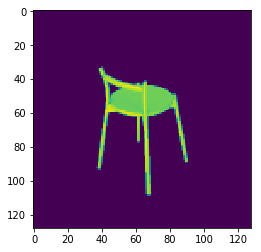

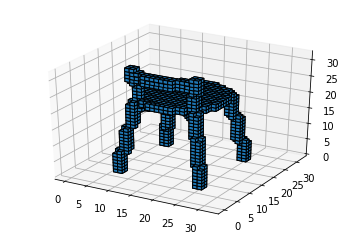

Predicted 3D object
Displaying the object


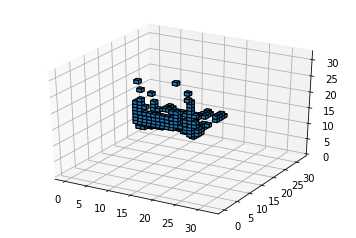

38
Real Image
torch.Size([1, 1, 128, 128])
torch.Size([32, 32, 32])
Displaying the object


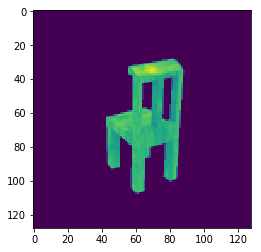

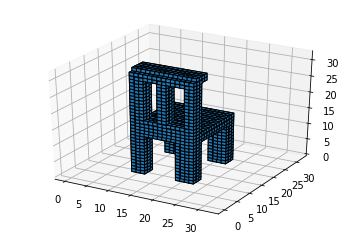

Predicted 3D object
Displaying the object


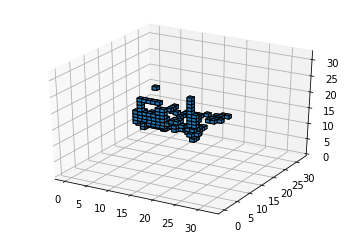

In [9]:
# Generate the 3D Object 
#Testing the general Structure of the VAE
import random
for j in range(0,2):
    i = random.randint(0,99)
    print(i)
    test_image = Variable(torch.FloatTensor(val_images[i])).view(1,1,128,128).cuda()
    print("Real Image")
    plt.imshow(test_image.squeeze().data.cpu().numpy())
    print(test_image.shape)
    test_object,_,_ = vae(test_image)
    test_object = test_object.squeeze().data.cpu().numpy()
    #print("Real 3D voxels")
    print(val_voxels[i].shape)
    display3DObject(Variable(val_voxels[i]).data.cpu().numpy())
    print("Predicted 3D object")
    display3DObject(test_object >0.5)
    

In [ ]:
torch.save(vae.state_dict(), 'vae_93.pt')

In [ ]:
#Testing the general Structure of the VAE
test_image = Variable(torch.FloatTensor(images[6])).view(1,1,128,128).cuda()
print(test_image.shape)
vae(test_image)